# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: November, 2025

**Student Name**: Axel Escoto García

**Professor**: Pablo Camarillo Ramirez

# Create SparkSession

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Final Project: Structured Streaming (Kafka)") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-06754acb-ccda-435b-ae9c-28a81d003984;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

# Commands to create Kafka Topic

## Topic creation
docker exec -it 8f890f706700 \
/opt/kafka/bin/kafka-topics.sh \
--create --zookeeper zookeeper:2181 \
--replication-factor 1 --partitions 1 \
--topic final-project-streaming

## Verificar que se creó
docker exec -it 8f890f706700 \
/opt/kafka/bin/kafka-topics.sh \
--list --zookeeper zookeeper:2181

## Execute producer
python3 fp_producer.py kafka:9093 final-project-streaming /opt/spark/work-dir/data/walmart_sales/Walmart_Sales.csv


# Dataset
Sourced from Kaggle: https://www.kaggle.com/datasets/mikhail1681/walmart-sales/data

In [3]:
from axel2293.spark_utils import SparkUtils

# Define the schema
sh = [
    ("Store", "int"),
    ("Date", "string"),
    ("Weekly_Sales", "double"),
    ("Holiday_Flag", "int"),
    ("Temperature", "double"),
    ("Fuel_Price", "double"),
    ("CPI", "double"),
    ("Unemployment", "double"),
    ("timestamp", "string"),
    ("iteration", "int"),
    ("record_id", "string")
]

sales_schema = SparkUtils.generate_schema(sh)

sales_schema

StructType([StructField('Store', IntegerType(), True), StructField('Date', StringType(), True), StructField('Weekly_Sales', DoubleType(), True), StructField('Holiday_Flag', IntegerType(), True), StructField('Temperature', DoubleType(), True), StructField('Fuel_Price', DoubleType(), True), StructField('CPI', DoubleType(), True), StructField('Unemployment', DoubleType(), True), StructField('timestamp', StringType(), True), StructField('iteration', IntegerType(), True), StructField('record_id', StringType(), True)])

# Create a data stream from a Kafka topic

In [4]:
# Create the remote connection
kafka_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9093") \
    .option("subscribe", "final-project-streaming") \
    .load()
kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



# Transformations

In [5]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

walmart_df = kafka_df.select(
    col("key").cast("string").alias("kafka_key"),
    from_json(col("value").cast("string"), sales_schema).alias("data"),
    col("timestamp").alias("kafka_timestamp")
).select("kafka_key", "data.*", "kafka_timestamp")

walmart_df.printSchema()

root
 |-- kafka_key: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Holiday_Flag: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- iteration: integer (nullable = true)
 |-- record_id: string (nullable = true)
 |-- kafka_timestamp: timestamp (nullable = true)



In [6]:
# Crear Month, Week, DayOfWeek, Quarter y Date_parsed
transformed_df = walmart_df.withColumn("Date_parsed", to_date(col("Date"), "dd-MM-yyyy"))

transformed_df = transformed_df.withColumn("Year", year(col("Date_parsed"))) \
    .withColumn("Month", month(col("Date_parsed"))) \
    .withColumn("Week", weekofyear(col("Date_parsed"))) \
    .withColumn("DayOfWeek", dayofweek(col("Date_parsed"))) \
    .withColumn("Quarter", quarter(col("Date_parsed")))

transformed_df.printSchema()

root
 |-- kafka_key: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Holiday_Flag: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- iteration: integer (nullable = true)
 |-- record_id: string (nullable = true)
 |-- kafka_timestamp: timestamp (nullable = true)
 |-- Date_parsed: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Quarter: integer (nullable = true)



## Divide into category

In [7]:
# Temperature categories (Cold, Moderate, Hot)
transformed_df = transformed_df.withColumn("Temp_Category",
    when(col("Temperature") < 40, "Cold")
    .when((col("Temperature") >= 40) & (col("Temperature") < 70), "Moderate")
    .otherwise("Hot"))

# Holiday labels (Holiday, Regular)
transformed_df = transformed_df.withColumn("Holiday_Label",
    when(col("Holiday_Flag") == 1, "Holiday")
    .otherwise("Regular"))

# Sales categories (Low, Medium, High)
transformed_df = transformed_df.withColumn("Sales_Category",
    when(col("Weekly_Sales") < 1000000, "Low")
    .when((col("Weekly_Sales") >= 1000000) & (col("Weekly_Sales") < 1500000), "Medium")
    .otherwise("High"))


## Calculate metrics

In [8]:
# Ventas por temperatura
transformed_df = transformed_df.withColumn("Sales_per_Temp",
    when(col("Temperature") > 0, col("Weekly_Sales") / col("Temperature"))
    .otherwise(lit(0)))

# Ratio de ventas en contraste con la tasa de desempleo 
transformed_df = transformed_df.withColumn("Sales_Unemployment_Ratio",
    when(col("Unemployment") > 0, col("Weekly_Sales") / col("Unemployment"))
    .otherwise(lit(0)))

# Impacto del costo de la gasolina
transformed_df = transformed_df.withColumn("Fuel_Cost_Impact",
    col("Fuel_Price") * col("Weekly_Sales") / 1000000)

# Flag que indica un alto CPI
transformed_df = transformed_df.withColumn("High_CPI_Flag",
    when(col("CPI") > 215, 1).otherwise(0))

# Flag para indicar un ratio alto de desempleo
transformed_df = transformed_df.withColumn("High_Unemployment_Flag",
    when(col("Unemployment") > 8, 1).otherwise(0))

# Processing timestamp
transformed_df = transformed_df.withColumn("processed_timestamp", current_timestamp())

# Aggregations

In [19]:
aggregated_df = transformed_df.groupBy("Store", "Year", "Month", "Holiday_Label") \
    .agg(
        sum("Weekly_Sales").alias("Total_Sales"),
        avg("Weekly_Sales").alias("Avg_Sales"),
        max("Weekly_Sales").alias("Max_Sales"),
        min("Weekly_Sales").alias("Min_Sales"),
        count("*").alias("Record_Count"),
        avg("Temperature").alias("Avg_Temperature"),
        avg("Fuel_Price").alias("Avg_Fuel_Price"),
        avg("CPI").alias("Avg_CPI"),
        avg("Unemployment").alias("Avg_Unemployment"),
        sum(when(col("Sales_Category") == "High", 1).otherwise(0)).alias("High_Sales_Count"),
        sum(when(col("Sales_Category") == "Medium", 1).otherwise(0)).alias("Medium_Sales_Count"),
        sum(when(col("Sales_Category") == "Low", 1).otherwise(0)).alias("Low_Sales_Count")
    ) \
    .orderBy(col("Max_Sales").desc())

# Check output and checkpoint dirs

In [10]:
!mkdir -p ../data/walmart_sales_processed
!mkdir -p ../data/walmart_sales_aggregated

!mkdir -p ../checkpoint/processed
!mkdir -p ../checkpoint/aggregated

# Write Processed Data

In [11]:
OUTPUT_PATH_PROCESSED = "../data/walmart_sales_processed"
CHECKPOINT_PATH_PROCESSED = "../checkpoint/processed"

# Partition by Year and MOnth
query_processed = transformed_df.writeStream \
    .outputMode("append") \
    .format("parquet") \
    .option("path", OUTPUT_PATH_PROCESSED) \
    .option("checkpointLocation", CHECKPOINT_PATH_PROCESSED) \
    .partitionBy("Year", "Month") \
    .trigger(processingTime="10 seconds") \
    .start()

25/11/24 03:26:09 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/24 03:26:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

In [12]:
query_processed.stop()

25/11/24 03:29:17 WARN DAGScheduler: Failed to cancel job group cbb70454-0917-43a9-a886-3808949d30e2. Cannot find active jobs for it.
25/11/24 03:29:17 WARN DAGScheduler: Failed to cancel job group cbb70454-0917-43a9-a886-3808949d30e2. Cannot find active jobs for it.


# Write Aggregated Data

In [20]:
OUTPUT_PATH_AGGREGATED = "../data/walmart_sales_aggregated"
CHECKPOINT_PATH_AGGREGATED = "../checkpoint/aggregated"

# Write aggregated data
query_aggregated = aggregated_df.writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("path", OUTPUT_PATH_AGGREGATED) \
    .option("checkpointLocation", CHECKPOINT_PATH_AGGREGATED) \
    .trigger(processingTime="30 seconds") \
    .start()

25/11/24 03:34:46 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/24 03:34:46 WARN StreamingQueryManager: Stopping existing streaming query [id=7431ef7e-9319-4ba6-a3b5-41137546204a, runId=81cd2a94-7a5b-485b-8014-017054ffe76c], as a new run is being started.
25/11/24 03:34:46 WARN DAGScheduler: Failed to cancel job group 81cd2a94-7a5b-485b-8014-017054ffe76c. Cannot find active jobs for it.
25/11/24 03:34:46 WARN DAGScheduler: Failed to cancel job group 81cd2a94-7a5b-485b-8014-017054ffe76c. Cannot find active jobs for it.


-------------------------------------------
Batch: 70
-------------------------------------------
+-----+----+-----+-------------+--------------------+------------------+----------+----------+------------+------------------+------------------+------------------+----------------+----------------+------------------+---------------+
|Store|Year|Month|Holiday_Label|         Total_Sales|         Avg_Sales| Max_Sales| Min_Sales|Record_Count|   Avg_Temperature|    Avg_Fuel_Price|           Avg_CPI|Avg_Unemployment|High_Sales_Count|Medium_Sales_Count|Low_Sales_Count|
+-----+----+-----+-------------+--------------------+------------------+----------+----------+------------+------------------+------------------+------------------+----------------+----------------+------------------+---------------+
|   14|2010|   12|      Regular|         4.5762227E7|      2860139.1875|3818686.45|2258489.63|          16|           33.1425|             3.109|       182.5704728|           8.724|              16|  

In [21]:
query_aggregated.stop()

25/11/24 03:36:54 WARN DAGScheduler: Failed to cancel job group 688688a5-1bca-43fe-bf6e-fd731ccf3d28. Cannot find active jobs for it.
25/11/24 03:36:54 WARN DAGScheduler: Failed to cancel job group 688688a5-1bca-43fe-bf6e-fd731ccf3d28. Cannot find active jobs for it.


# Check

In [22]:
!ls ../data/walmart_sales_processed

 _spark_metadata  'Year=2011'  'year=__HIVE_DEFAULT_PARTITION__'
'Year=2010'	  'Year=2012'


# Monitoreo

In [23]:
query_console = transformed_df.select(
    "Store", "Date_parsed", "Weekly_Sales", 
    "Holiday_Label", "Sales_Category", "Temp_Category"
).writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", "false") \
    .option("numRows", 5) \
    .trigger(processingTime="30 seconds") \
    .start()

25/11/24 03:37:01 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-b74ce37f-d6d1-4dc0-8de6-cf326b0bf2e1. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/24 03:37:01 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+-----+-----------+------------+-------------+--------------+-------------+
|Store|Date_parsed|Weekly_Sales|Holiday_Label|Sales_Category|Temp_Category|
+-----+-----------+------------+-------------+--------------+-------------+
|18   |2011-03-18 |945889.59   |Regular      |Low           |Moderate     |
+-----+-----------+------------+-------------+--------------+-------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+-----+-----------+------------+-------------+--------------+-------------+
|Store|Date_parsed|Weekly_Sales|Holiday_Label|Sales_Category|Temp_Category|
+-----+-----------+------------+-------------+--------------+-------------+
|18   |2011-03-25 |944523.3    |Regular      |Low           |Cold         |
|18   |2011-04-01 |938083.17   |Regular      |Low           |Cold         |
|18   |2011-04-08 |1018541.3   |Regular      

In [24]:
query_console.stop()

25/11/24 03:38:57 WARN DAGScheduler: Failed to cancel job group 53dbe617-6071-4d30-b707-244c32b40024. Cannot find active jobs for it.
25/11/24 03:38:57 WARN DAGScheduler: Failed to cancel job group 53dbe617-6071-4d30-b707-244c32b40024. Cannot find active jobs for it.


In [25]:
sc.stop()

# Producer Output
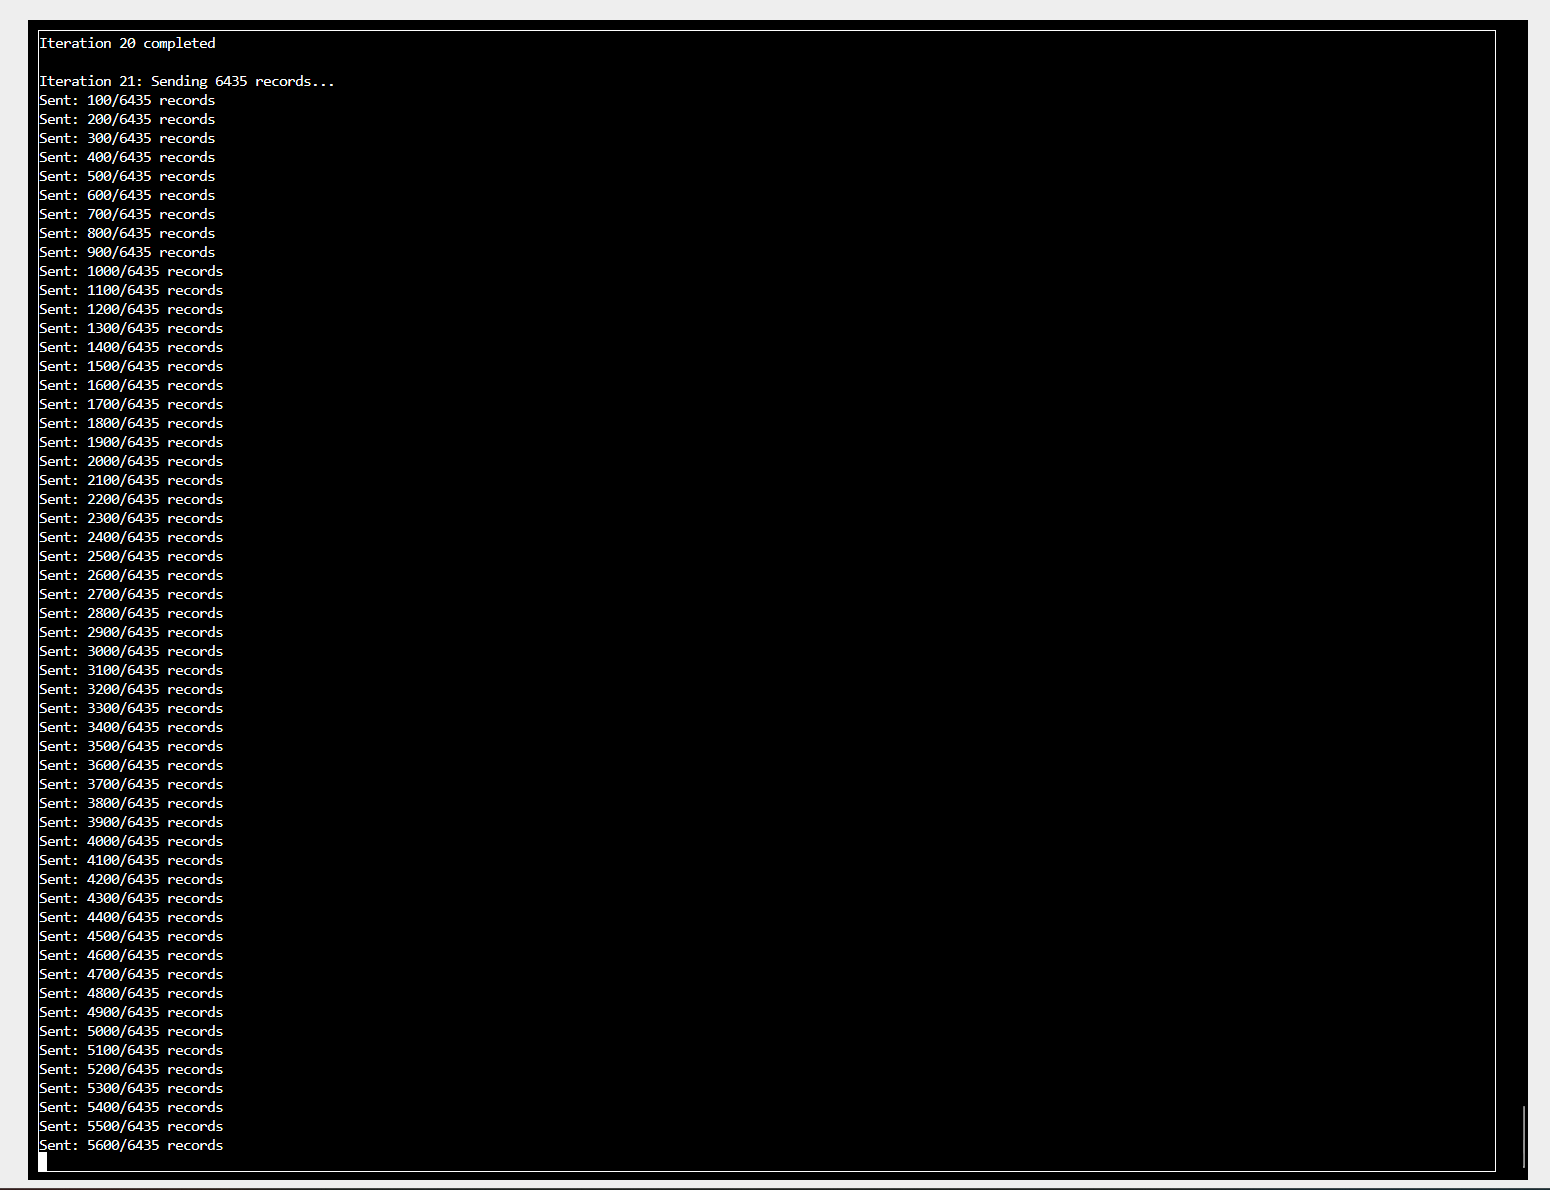

# Power BI Dashboard
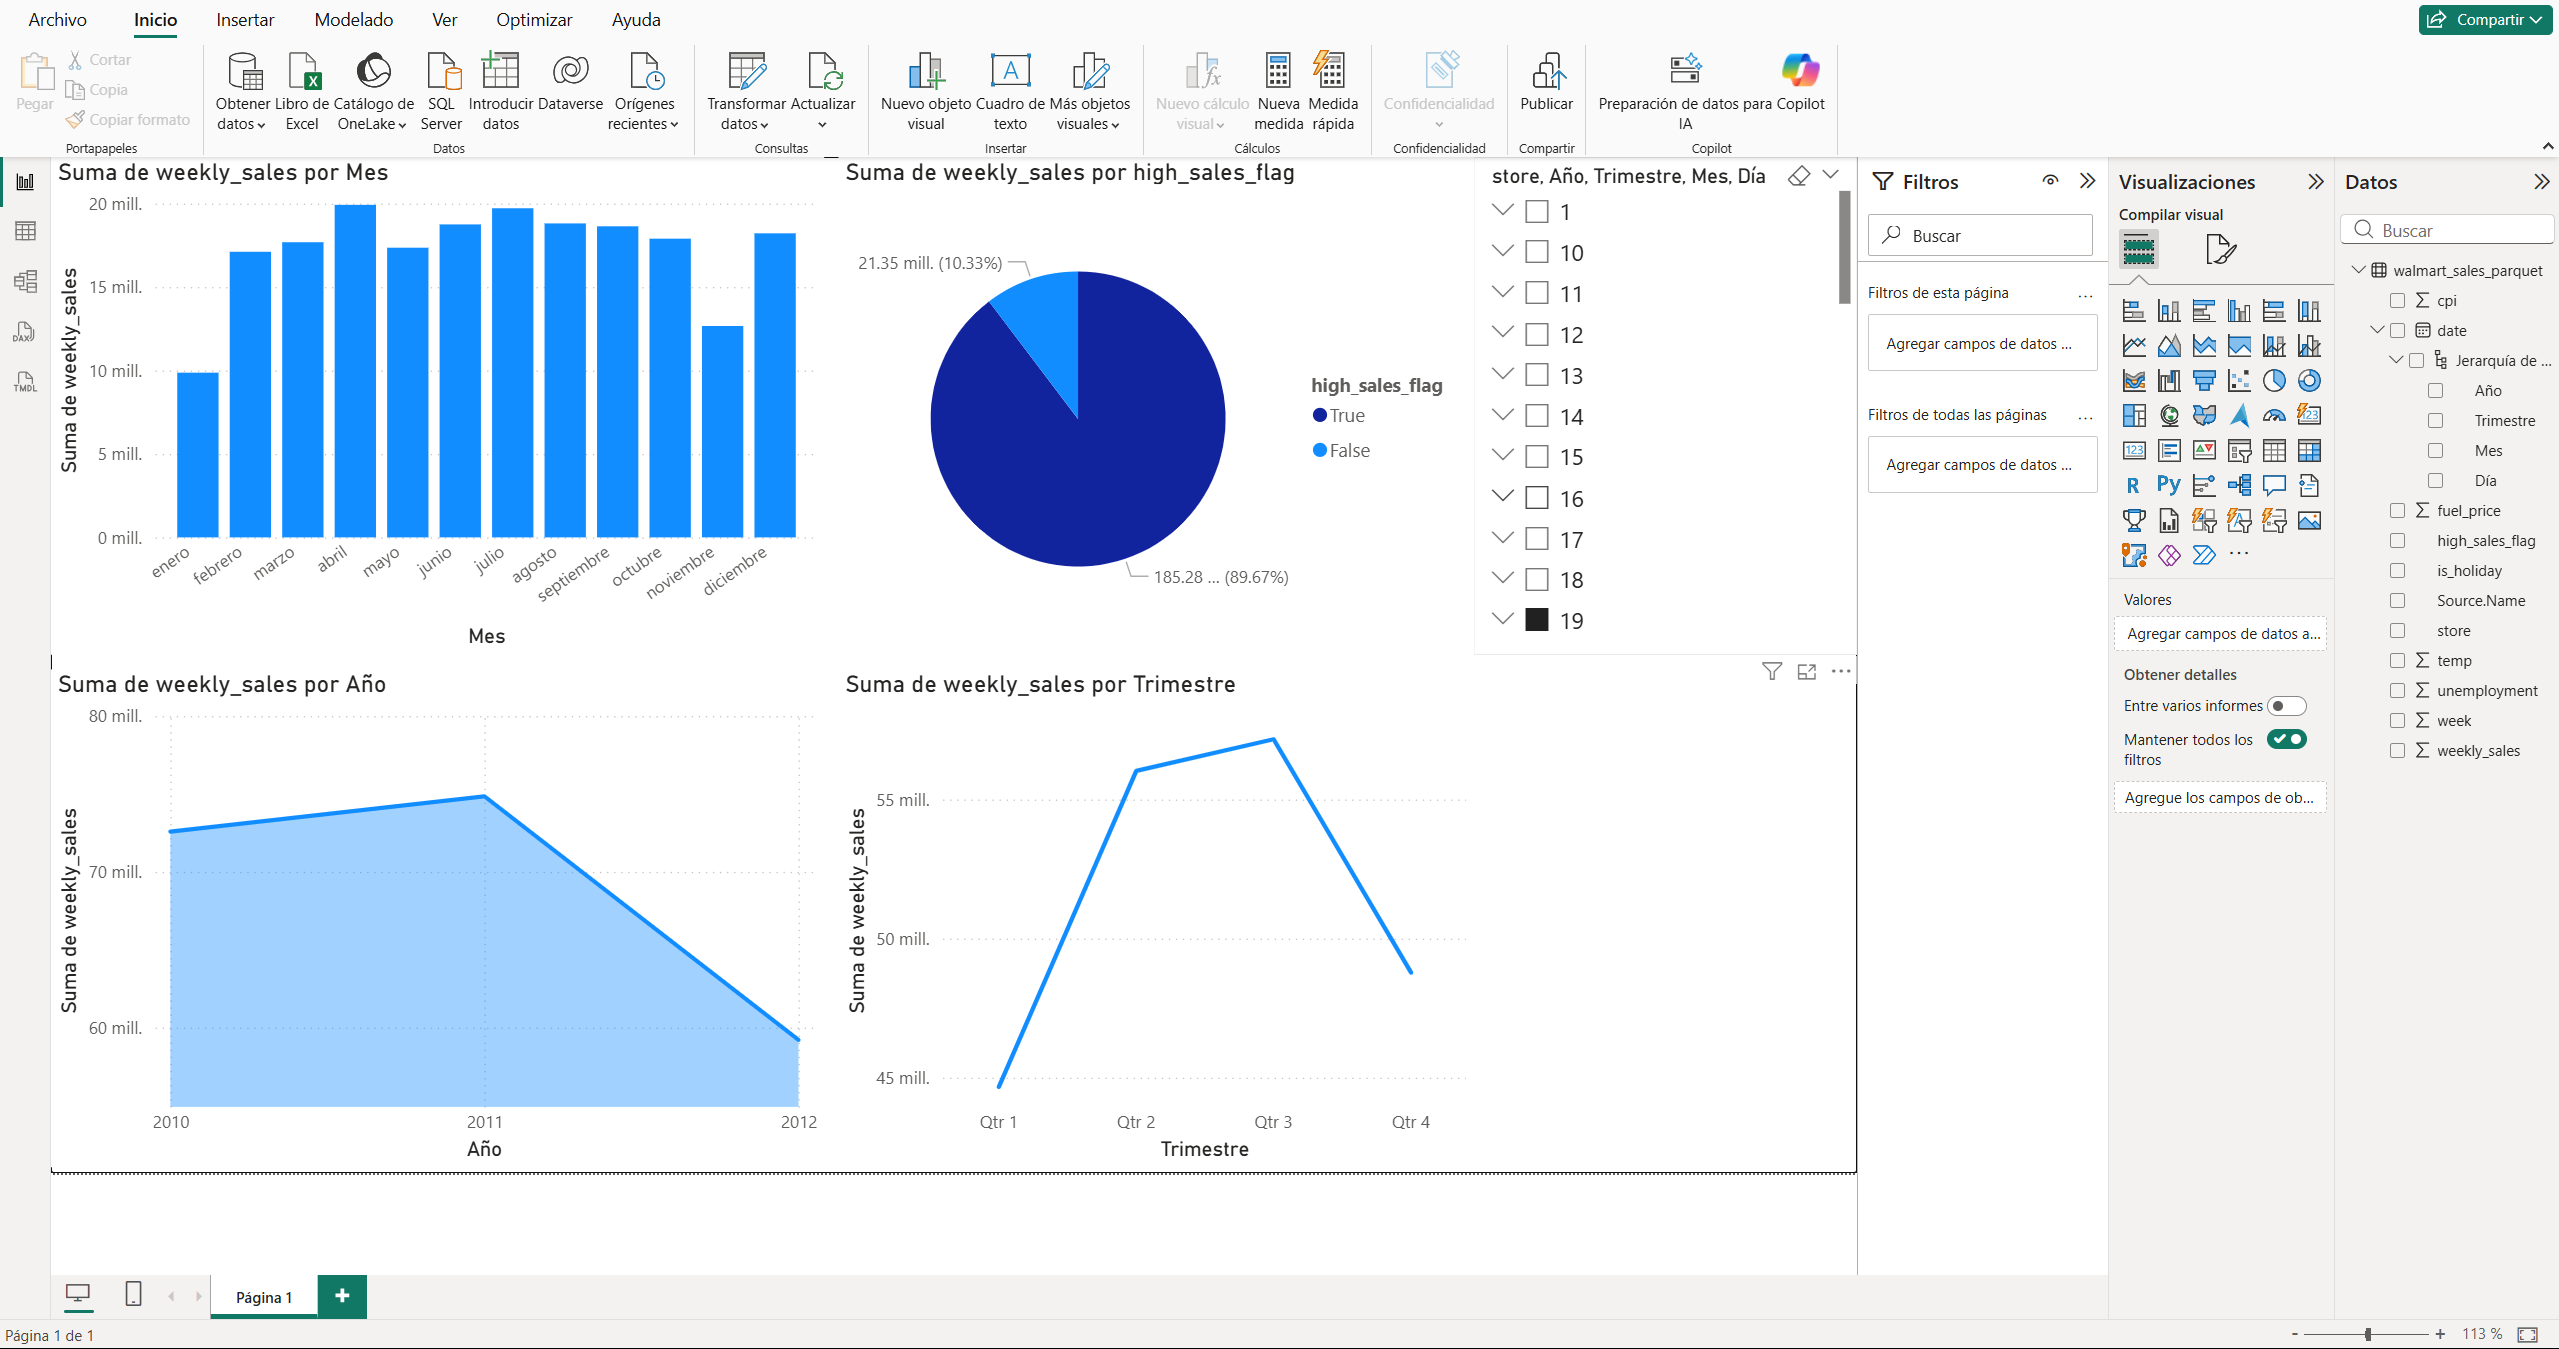